In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import yfinance as yf

In [2]:
org = yf.Ticker('ORA.PA')
with open('org.csv', "w") as f:
  org.history(period="max").to_csv(f)

df = pd.read_csv('org.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03 00:00:00+01:00,32.255717,32.982197,31.601885,31.722965,1551490,0.0,0.0
1,2000-01-04 00:00:00+01:00,31.577658,31.601876,29.301356,30.027836,1988788,0.0,0.0
2,2000-01-05 00:00:00+01:00,28.429598,29.495103,28.308518,28.453814,2593952,0.0,0.0
3,2000-01-06 00:00:00+01:00,28.574891,29.204506,26.903986,28.090570,2847297,0.0,0.0
4,2000-01-07 00:00:00+01:00,27.388306,29.204507,27.243011,28.938131,1593258,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6590 entries, 0 to 6589
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6590 non-null   object 
 1   Open          6590 non-null   float64
 2   High          6590 non-null   float64
 3   Low           6590 non-null   float64
 4   Close         6590 non-null   float64
 5   Volume        6590 non-null   int64  
 6   Dividends     6590 non-null   float64
 7   Stock Splits  6590 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 412.0+ KB


In [7]:
close_price = df["Close"]
scaler = MinMaxScaler()
scaled_price_reshaped = scaler.fit_transform(close_price.values.reshape(-1, 1))

In [9]:
def create_window(df, lookback_window):
  X=[]
  y=[]
  for i in range(len(df)-lookback_window):
    X.append(df[i: i+lookback_window])
    y.append(df[i+lookback_window])
  return np.array(X), np.array(y)

X,y = create_window(scaled_price_reshaped, 60)

X.shape, y.shape

((6530, 60, 1), (6530, 1))

In [10]:
X_train, y_train = X[:6001], y[:6001]
X_test, y_test = X[6001:6401], y[6001:6401]
X_val, y_val = X[6401:], y[6401:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((6001, 60, 1), (6001, 1), (400, 60, 1), (400, 1), (129, 60, 1), (129, 1))

In [22]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=32))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,417 (501.63 KB)

 Trainable params: 128,417 (501.63 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [24]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - loss: 0.0025 - root_mean_squared_error: 0.0449 - val_loss: 8.9124e-05 - val_root_mean_squared_error: 0.0094
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 3.4543e-04 - root_mean_squared_error: 0.0186 - val_loss: 4.1835e-05 - val_root_mean_squared_error: 0.0065
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - loss: 3.4612e-04 - root_mean_squared_error: 0.0186 - val_loss: 2.7666e-05 - val_root_mean_squared_error: 0.0053
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - loss: 3.4271e-04 - root_mean_squared_error: 0.0184 - val_loss: 1.4670e-04 - val_root_mean_squared_error: 0.0121
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - loss: 3.2537e-04 - root_mean_squared_error: 0.0180 - val_loss: 2.3455e-05 - val_root_mean_squared_error: 0.0048
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - loss: 2.5199e-04 - root_mean_squared_error: 0.0158 - val_loss: 1.8092e-05 - val_root_mean_squared_erro

In [25]:
predicted = model.predict(X_val)
predicted = scaler.inverse_transform(predicted)
actual_price = scaler.inverse_transform(y_val.reshape(-1,1))

mse_score = MeanSquaredError()(actual_price, predicted).numpy()
rmse_score = RootMeanSquaredError()(actual_price, predicted).numpy()

print(f"MSE: {mse_score}")
print(f"RMSE: {rmse_score}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step
MSE: 0.06792736798524857
RMSE: 0.2606287896633148


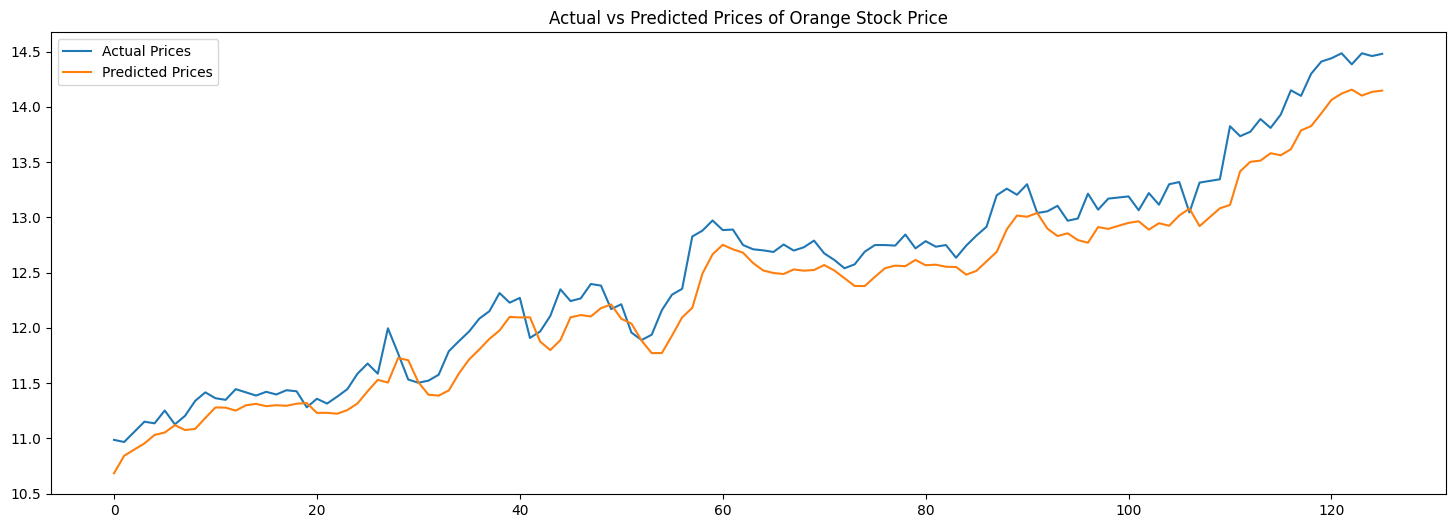

In [26]:
num_of_days_in_6_months = 6*21
if num_of_days_in_6_months > len(y_val):
  num_of_days_in_6_months = len(y_val)

plt.figure(figsize=(18,6))
plt.plot(actual_price[-num_of_days_in_6_months:], label='Actual Prices')
plt.plot(predicted[-num_of_days_in_6_months:], label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted Prices of Orange Stock Price')
plt.show()